<a href="https://colab.research.google.com/github/sabinaaskerova/CTronGame/blob/main/Optim_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sabina Askerova

IASD

In [ ]:
# Display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt # Square root
from math import ceil # Ceil integer operator
from math import log # Logarithm function

import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform # Probability distributions

from scipy.linalg import toeplitz # Toeplitz matrices
from scipy.linalg import norm # Euclidean norm
from scipy.linalg import svdvals # Singular value decomposition
from scipy.linalg import qr # QR decomposition from linear algebra
from scipy.optimize import check_grad # Numerical check of derivatives
from scipy.optimize import fmin_l_bfgs_b # An efficient minimization routine in moderate dimensions

import pandas as pd
import torch

Question 1 Select a training dataset for binary classification of the form {(ai
, yi)}
n
i=1 with ai ∈ R
d
and yi ∈ {0, 1}. Comment briefly on this dataset: what are the problem dimensions, what does the
correlation matrix look like, etc.

Dataset description:

Number of classes: 2

Number of data: 8124

Number of features: 112

In [12]:

csv_file = "mushrooms.csv"  # Replace with your CSV file path
data = pd.read_csv(csv_file, header=None)[0]  # Assuming data is in the first column

# Initialize an empty list to store rows
rows = []

# Parse each row
for row in data:
    parts = row.split()
    label = int(parts[0])  # Extract the label
    features = {int(f.split(":")[0]): int(f.split(":")[1]) for f in parts[1:]}  # Parse features
    row_dict = {"label": label, **features}
    rows.append(row_dict)

# Create a DataFrame from the rows
df = pd.DataFrame(rows)

# Replace NaN with 0 (for features that are missing)
df = df.fillna(0)

# Ensure all features (columns) from 1 to 112 are present
all_features = ["label"] + list(range(1, 113))
df = df.reindex(columns=all_features, fill_value=0)


Number of samples (n): 8124
Number of features (d): 112 (excluding the label column)


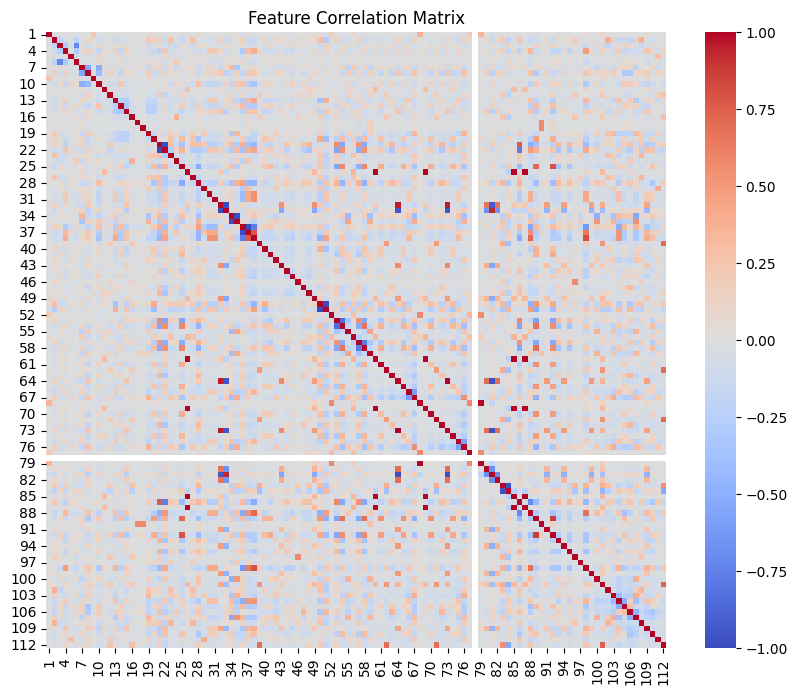

In [ ]:
n, d = df.shape
print(f"Number of samples (n): {n}")
print(f"Number of features (d): {d - 1} (excluding the label column)")

# Compute the correlation matrix for the features only
feature_columns = df.columns[1:]  # Exclude the label column
correlation_matrix = df[feature_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Matrix")
plt.show()


There are not a lot of features that are correlated to each other. The correlation matrix is pretty homogenous

### Question 2

Given a data point (ai
, yi) from your dataset, use the Autograd framework described
in the second lab session to implement a code for the function fi that enables to compute ∇fi(x) for
any x through automatic differentiation. Validate your implementation using the explicit formula (2)

In [13]:
y = df['label'].to_numpy()
A = df.drop(columns=['label']).to_numpy()
A_tensor = torch.tensor(A, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [28]:
class LogisticRegressionProblem:
    def __init__(self, A, y):
        self.A = A
        self.y = y
        self.n = len(y)
        self.d = A.shape[1]

    @staticmethod
    def sigmoid_fn(z):
        return np.where(z >= 0,
                        1 / (1 + np.exp(-z)),
                        np.exp(z) / (1 + np.exp(z)))

    def fun(self, x):
        """Compute full objective function"""
        sig = self.sigmoid_fn(self.A @ x)
        return np.mean((self.y - sig) ** 2)

    def grad_i(self, i, x):
        """Compute gradient for i-th sample"""
        a_i = self.A[i]
        y_i = self.y[i]
        dot_product = np.dot(a_i, x)
        # Clip for numerical stability
        dot_product = np.clip(dot_product, -500, 500)
        exp_term = np.exp(dot_product)
        numerator = -2 * exp_term * (exp_term * (y_i - 1) + y_i)
        denominator = (1 + exp_term) ** 3
        return (numerator / denominator) * a_i

    def explicit_gradient(self, x, a_i, y_i):
        dot_product = np.dot(a_i, x)
        dot_product = np.clip(dot_product, -500, 500)
        exp_term = np.exp(dot_product)
        numerator = -2 * exp_term * (exp_term * (y_i - 1) + y_i)
        denominator = (1 + exp_term) ** 3
        return (numerator / denominator) * a_i

    def explicit_full_gradient(self, x):
        dot_products = self.A @ x
        dot_products = np.clip(dot_products, -500, 500)
        exp_terms = np.exp(dot_products)
        numerator = -2 * exp_terms * (exp_terms * (self.y - 1) + self.y)
        denominator = (1 + exp_terms) ** 3
        return np.mean((numerator / denominator).reshape(-1, 1) * self.A, axis=0)

    # def full_gradient(self, x):
    #     """Compute average gradient across all samples vectorized"""
    #     dot_products = self.A @ x  # Compute all dot products at once
    #     dot_products = np.clip(dot_products, -500, 500)  # Numerical stability
    #     exp_terms = np.exp(dot_products)
    #     numerator = -2 * exp_terms * (exp_terms * (self.y - 1) + self.y)
    #     denominator = (1 + exp_terms) ** 3
    #     return np.mean((numerator / denominator).reshape(-1, 1) * self.A, axis=0)

    def autograd_gradient(self, x):
        """Compute gradient using PyTorch autograd"""
        import torch
        x_torch = torch.tensor(x, requires_grad=True, dtype=torch.float64)
        A_torch = torch.tensor(self.A, dtype=torch.float64)
        y_torch = torch.tensor(self.y, dtype=torch.float64)

        pred = 1 / (1 + torch.exp(-torch.matmul(A_torch, x_torch)))
        loss = torch.mean((y_torch - pred) ** 2)

        loss.backward()
        return x_torch.grad.detach().numpy()

    def lipgrad(self):
        """Estimate Lipschitz constant"""
        return np.max(np.linalg.norm(self.A, axis=1)) ** 2


In [30]:
n_samples = df.shape[0]
n_features = df.shape[1] - 1

# Instantiate the problem
problem = LogisticRegressionProblem(A, y)

# Initialize a random point x
x = np.random.randn(n_features)

# Compute gradients
explicit_grad = problem.explicit_full_gradient(x)
autograd_grad = problem.autograd_gradient(x)

# Compute norms
explicit_grad_norm = np.linalg.norm(explicit_grad)
autograd_grad_norm = np.linalg.norm(autograd_grad)

# Compare the results
print("Explicit Gradient Norm:", explicit_grad_norm)
print("Autograd Gradient Norm:", autograd_grad_norm)
print("Difference in Norms:", abs(explicit_grad_norm - autograd_grad_norm))
print("Are the gradients approximately equal?", np.allclose(explicit_grad, autograd_grad, atol=1e-6))


Explicit Gradient Norm: 0.4783404421158433
Autograd Gradient Norm: 0.47834044211584337
Difference in Norms: 5.551115123125783e-17
Are the gradients approximately equal? True


We can see that the gradients calculated with Autograd and explicitly calculated gradients coincide.

## First-order algorithms

### Question 3
Adapt the code of gradient descent provided during the lab sessions (or use your own
implementation) to run it on problem (1).

• What convergence rate is expected for gradient descent on this problem? Do you observe this
rate empirically?

• Can you find a good constant value for the stepsize?

TODO : play with stepsize
TODO : comment on convergence rates
TODO : show statistics and results

### Question 4

Adapt the code of batch stochastic gradient provided during the third lab session (or
use your own implementation) to compare gradient descent and stochastic gradient on problem (1).

• Are your results consistent with what the theory predicts?

• Can you find a good constant stepsize choice for stochastic gradient? What appears to be the
best value for the batch size on this problem?

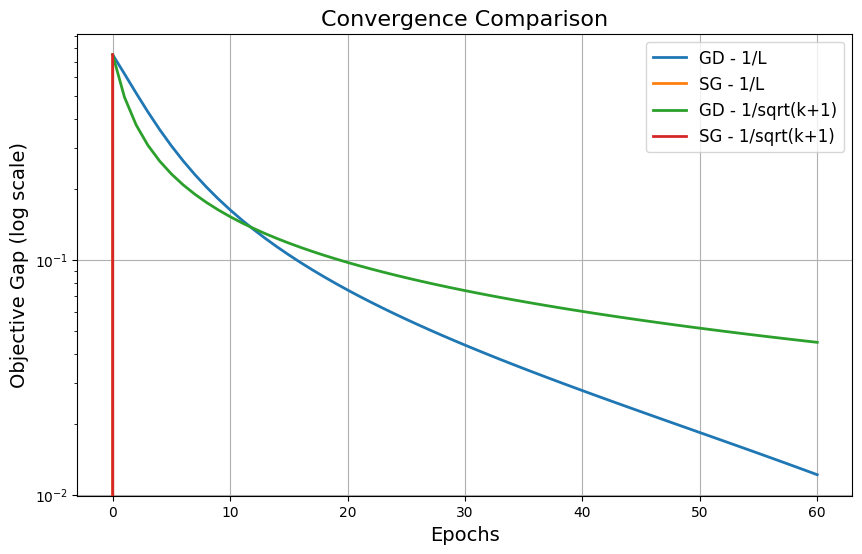

In [25]:
def stoch_grad(x0, problem, xtarget, stepchoice=0, step0=1, n_iter=1000, nb=1, verbose=False):
    """
    Stochastic gradient descent implementation

    Args:
        x0: Initial point
        problem: Problem instance
        xtarget: Optimal point (for tracking distance)
        stepchoice: 0 for constant step size, >0 for decreasing step size
        step0: Initial step size
        n_iter: Number of iterations
        nb: Batch size (nb=n for full gradient descent)
        verbose: Whether to print progress
    """
    # Initialize
    x = x0.copy()
    objvals = []
    normits = []
    L = problem.lipgrad()
    n = problem.n

    # Track initial values
    obj = problem.fun(x)
    objvals.append(obj)
    normits.append(np.linalg.norm(x - xtarget))

    for k in range(n_iter):
        # Sample batch
        if nb == n:  # Full gradient
            batch_indices = np.arange(n)
        else:  # Stochastic gradient
            batch_indices = np.random.choice(n, nb, replace=False)

        # Compute gradient
        sg = np.zeros_like(x0)
        for idx in batch_indices:
            sg += problem.grad_i(idx, x)
        sg /= len(batch_indices)

        # Update step size
        if stepchoice == 0:
            step = step0 / L
        else:
            step = step0 / ((k + 1) ** stepchoice)

        # Update parameters
        x = x - step * sg

        # Track progress at the end of each epoch
        if ((k+1) * nb) % n == 0 or k == n_iter-1:
            obj = problem.fun(x)
            nmin = np.linalg.norm(x - xtarget)
            objvals.append(obj)
            normits.append(nmin)

            if verbose:
                print(f"Iter {k+1}, Obj: {obj:.2e}, Dist: {nmin:.2e}")

    return x, np.array(objvals), np.array(normits)

# Setup problem
d = A.shape[1]  # dimension
x0 = np.zeros(d)  # initial point
problem = LogisticRegressionProblem(A, y)

# Compute minimum objective (using gradient descent with small step size)
x_min, f_min, _ = stoch_grad(x0, problem, x0, stepchoice=0, step0=0.1, n_iter=1000, nb=len(y))
f_min_log = f_min[-1]

# Run experiments
nb_epochs = 60
n = len(y)
nbset = 1

# Run variants
x_a, obj_a, _ = stoch_grad(x0, problem, x_min, stepchoice=0, step0=1, n_iter=nb_epochs, nb=n)
x_b, obj_b, _ = stoch_grad(x0, problem, x_min, stepchoice=0, step0=1, n_iter=int(nb_epochs*n/nbset), nb=nbset)
x_c, obj_c, _ = stoch_grad(x0, problem, x_min, stepchoice=0.5, step0=0.1, n_iter=nb_epochs, nb=n)
x_d, obj_d, _ = stoch_grad(x0, problem, x_min, stepchoice=0.5, step0=0.1, n_iter=int(nb_epochs*n/nbset), nb=nbset)

# Plot results
plt.figure(figsize=(10, 6))
plt.semilogy(obj_a - f_min_log, label="GD - 1/L", lw=2)
plt.semilogy(obj_b - f_min_log, label="SG - 1/L", lw=2)
plt.semilogy(obj_c - f_min_log, label="GD - 1/sqrt(k+1)", lw=2)
plt.semilogy(obj_d - f_min_log, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence Comparison", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Objective Gap (log scale)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [38]:
# GD and SG implementation
def gd_sg(x0, problem, xtarget, stepchoice=0, step0=1, n_iter=1000, nb=1, verbose=False):
    x = x0.copy()
    objvals = []
    normits = []
    L = problem.lipgrad()
    n = problem.n

    objvals.append(problem.fun(x))
    normits.append(np.linalg.norm(x - xtarget))

    for k in range(n_iter):
        if nb == n:  # Full gradient
            grad = problem.explicit_full_gradient(x)
        else:  # Stochastic gradient
            batch_indices = np.random.choice(n, nb, replace=False)
            grad = np.mean([problem.grad_i(i, x) for i in batch_indices], axis=0)

        if stepchoice == 0:
            step = step0 / L
        else:
            step = step0 / ((k + 1) ** stepchoice)

        x = x - step * grad

        if (k + 1) % (n // nb) == 0 or k == n_iter - 1:
            objvals.append(problem.fun(x))
            normits.append(np.linalg.norm(x - xtarget))
            if verbose:
                print(f"Iter {k+1}, Obj: {objvals[-1]:.2e}, Dist: {normits[-1]:.2e}")

    return x, np.array(objvals), np.array(normits)

def run_experiments_and_plot(A, y, x_min, f_min):
    problem = LogisticRegressionProblem(A, y)
    x0 = np.zeros(problem.d)

    # Define parameters for the experiments
    step0_gd = 1.0
    step0_sg = 1.0
    step_decreasing = 0.5
    nb_epochs = 60
    n_iter_per_epoch = problem.n
    n_total_iters = nb_epochs * n_iter_per_epoch

    # Run experiments
    x_gd_const, obj_gd_const, _ = gd_sg(x0, problem, x_min, stepchoice=0, step0=step0_gd, n_iter=nb_epochs, nb=problem.n)
    x_sg_const, obj_sg_const, _ = gd_sg(x0, problem, x_min, stepchoice=0, step0=step0_sg, n_iter=n_total_iters, nb=1)
    x_gd_decr, obj_gd_decr, _ = gd_sg(x0, problem, x_min, stepchoice=step_decreasing, step0=step0_gd, n_iter=nb_epochs, nb=problem.n)
    x_sg_decr, obj_sg_decr, _ = gd_sg(x0, problem, x_min, stepchoice=step_decreasing, step0=step0_sg, n_iter=n_total_iters, nb=1)

    # Ensure lengths match by slicing or downsampling
    min_len = min(len(obj_gd_const), len(obj_sg_const), len(obj_gd_decr), len(obj_sg_decr))
    obj_gd_const = obj_gd_const[:min_len]
    obj_sg_const = obj_sg_const[:min_len]
    obj_gd_decr = obj_gd_decr[:min_len]
    obj_sg_decr = obj_sg_decr[:min_len]

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.semilogy(obj_gd_const - f_min, label="GD - 1/L", lw=2)
    plt.semilogy(obj_sg_const - f_min, label="SG - 1/L", lw=2)
    plt.semilogy(obj_gd_decr - f_min, label="GD - 1/sqrt(k+1)", lw=2)
    plt.semilogy(obj_sg_decr - f_min, label="SG - 1/sqrt(k+1)", lw=2)

    plt.title("Convergence Comparison", fontsize=16)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Objective Gap (log scale)", fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()



In [33]:
# Define initial parameters and problem instance
x0 = np.zeros(problem.d)  # Start with zero vector
large_step0 = 0.01
large_n_iter = 5000

# Run gradient descent to approximate xmin
xmin, _, _ = gd_sg(x0, problem, x0, stepchoice=0.5, step0=large_step0, n_iter=large_n_iter, nb=problem.n, verbose=True)

# Calculate fmin
fmin = problem.fun(xmin)

print("Approximated xmin:", xmin)
print("Approximated fmin:", fmin)


Streaming output truncated to the last 5000 lines.
Iter 30, Obj: 1.06e+00, Dist: 1.48e-01
Iter 31, Obj: 1.05e+00, Dist: 1.51e-01
Iter 32, Obj: 1.05e+00, Dist: 1.53e-01
Iter 33, Obj: 1.05e+00, Dist: 1.56e-01
Iter 34, Obj: 1.04e+00, Dist: 1.58e-01
Iter 35, Obj: 1.04e+00, Dist: 1.60e-01
Iter 36, Obj: 1.04e+00, Dist: 1.62e-01
Iter 37, Obj: 1.03e+00, Dist: 1.65e-01
Iter 38, Obj: 1.03e+00, Dist: 1.67e-01
Iter 39, Obj: 1.03e+00, Dist: 1.69e-01
Iter 40, Obj: 1.03e+00, Dist: 1.71e-01
Iter 41, Obj: 1.02e+00, Dist: 1.73e-01
Iter 42, Obj: 1.02e+00, Dist: 1.75e-01
Iter 43, Obj: 1.02e+00, Dist: 1.77e-01
Iter 44, Obj: 1.01e+00, Dist: 1.79e-01
Iter 45, Obj: 1.01e+00, Dist: 1.81e-01
Iter 46, Obj: 1.01e+00, Dist: 1.83e-01
Iter 47, Obj: 1.01e+00, Dist: 1.85e-01
Iter 48, Obj: 1.00e+00, Dist: 1.87e-01
Iter 49, Obj: 1.00e+00, Dist: 1.89e-01
Iter 50, Obj: 1.00e+00, Dist: 1.91e-01
Iter 51, Obj: 9.97e-01, Dist: 1.93e-01
Iter 52, Obj: 9.95e-01, Dist: 1.94e-01
Iter 53, Obj: 9.93e-01, Dist: 1.96e-01
Iter 54, Obj:

In [41]:
fmin

0.5840474914444924

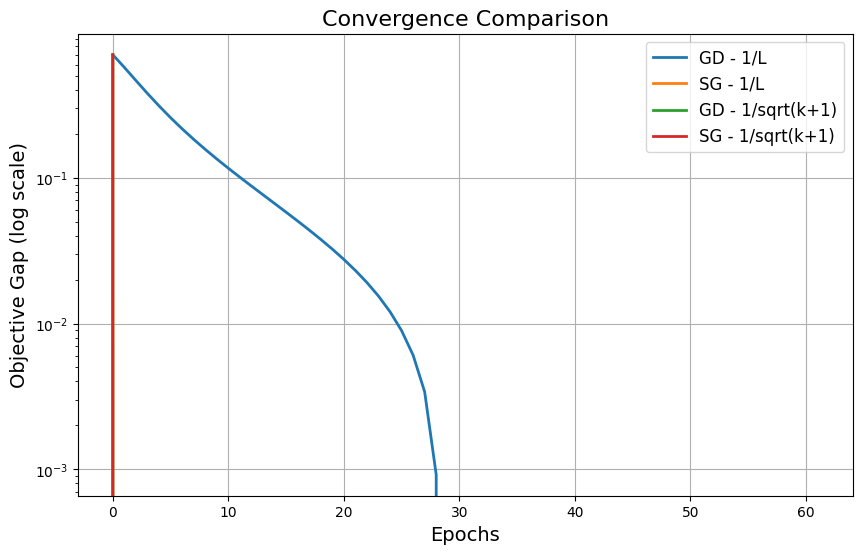

In [42]:
# Define parameters
x0 = np.zeros(problem.d)  # Initial point
step0_gd = 1.0            # Initial step size for GD
step0_sg = 1.0            # Initial step size for SG
step_decreasing = 0.5     # Step size decrease rate
nb_epochs = 60            # Number of epochs
nbset = 32                # Batch size for SG
f_min_log = fmin         # Ensure f_min is a scalar

# Run variants
x_gd_const, obj_gd_const, _ = gd_sg(x0, problem, x_min, stepchoice=0, step0=step0_gd, n_iter=nb_epochs, nb=problem.n)
x_sg_const, obj_sg_const, _ = gd_sg(x0, problem, x_min, stepchoice=0, step0=step0_sg, n_iter=int(nb_epochs * problem.n / nbset), nb=nbset)
x_gd_decr, obj_gd_decr, _ = gd_sg(x0, problem, x_min, stepchoice=step_decreasing, step0=step0_gd, n_iter=nb_epochs, nb=problem.n)
x_sg_decr, obj_sg_decr, _ = gd_sg(x0, problem, x_min, stepchoice=step_decreasing, step0=step0_sg, n_iter=int(nb_epochs * problem.n / nbset), nb=nbset)

# Plot results
plt.figure(figsize=(10, 6))
plt.semilogy(obj_gd_const - f_min_log, label="GD - 1/L", lw=2)
plt.semilogy(obj_sg_const - f_min_log, label="SG - 1/L", lw=2)
plt.semilogy(obj_gd_decr - f_min_log, label="GD - 1/sqrt(k+1)", lw=2)
plt.semilogy(obj_sg_decr - f_min_log, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence Comparison", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Objective Gap (log scale)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


Test bathc sizes for same stepsize with and without replacement

In [ ]:
valsstep0 = [1,0.1,0.01,0.001,0.0001]

### Question 5
Adapt the code of Adagrad provided during the third lab session (or use your own
implementation) to include that method in the comparison.

How does this method compare to the
best stochastic gradient method from Question 4 on problem (1)?

 TODO : find good regime of setting the parameters
scale idea adagrad (adapt stepsize wrt coordinates)

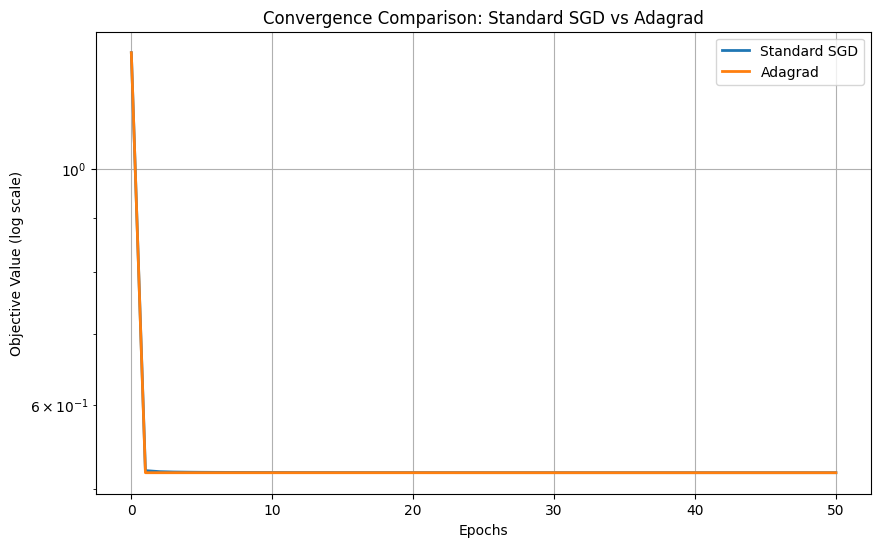

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def adagrad_sgd(x0, A, y, step0=1.0, n_iter=1000, batch_size=1, eps=1e-8):
    """
    Adagrad implementation for logistic regression

    Args:
        x0: Initial parameters
        A: Feature matrix
        y: Labels
        step0: Initial step size
        n_iter: Number of iterations
        batch_size: Mini-batch size
        eps: Small constant for numerical stability
    """
    n, d = A.shape
    x = x0.copy()
    v = np.zeros(d)  # Accumulator for squared gradients
    objvals = []

    # Track initial objective
    objvals.append(objective_function(x, A, y))

    for k in range(n_iter):
        # Sample batch
        batch_idx = np.random.choice(n, batch_size, replace=False)

        # Compute gradient for batch
        grad = explicit_full_gradient(x, A[batch_idx], y[batch_idx])

        # Update accumulator
        v += grad * grad

        # Compute adaptive learning rates
        adaptive_rates = step0 / (np.sqrt(v + eps))

        # Update parameters
        x = x - adaptive_rates * grad

        # Track objective (using full dataset)
        if (k + 1) % (n // batch_size) == 0 or k == n_iter - 1:
            objvals.append(objective_function(x, A, y))

    return x, np.array(objvals)

# Run comparison experiments
d = A.shape[1]
x0 = np.zeros(d)
n_epochs = 50

# Run standard SGD with constant step size
x_sgd, obj_sgd = stoch_grad(x0, A, y,
                           stepsize_strategy='constant',
                           stepsize=0.1,
                           n_iter=n_epochs * len(y),
                           batch_size=1)

# Run Adagrad
x_adagrad, obj_adagrad = adagrad_sgd(x0, A, y,
                                    step0=1.0,
                                    n_iter=n_epochs * len(y),
                                    batch_size=1)

# Plot convergence comparison
plt.figure(figsize=(10, 6))
plt.semilogy(obj_sgd, label='Standard SGD', lw=2)
plt.semilogy(obj_adagrad, label='Adagrad', lw=2)
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Objective Value (log scale)')
plt.title('Convergence Comparison: Standard SGD vs Adagrad')
plt.legend()
plt.show()

### Question 6

Consider the best method from Question 5, and apply it to problem (3) using the
proximal gradient approach from the fourth lab session.

Can you find a value for λ that yields a
good yet sparse solution vector?

# Quasi-Newton techniques

### Question 7
Implement the BFGS method, and compare its performance with that of gradient descent on problem (1).

### Question 8
Adapt the code from Question 7 so that the algorithm uses a stochastic gradient (obtained using a batch of indices) in lieu of the true gradient.
Compare the resulting methods with
their (batch) stochastic gradient counterparts

### Question 9

Compare your best stochastic BFGS variant with Adagrad using the following metrics:

• Number of accesses to data points.

• Number of d-dimensional vectors updated at every iteration.

### Question 10

Generalize the approach used in Question 6 to BFGS techniques.

How does the
resulting methods compare to that used in Question 6 on the regularized problem (3) for a fixed value of λ?

### Question 11

Implement the L-BFGS variant (see below) for m = 0, 5, 10, and compare it with the
deterministic Question 7.

### Question 12

Replace BFGS by L-BFGS in one of the questions 8–10, and answer the question.

Remark: The (L-)BFGS codes are not meant to be identical or competitive to that of scipy or
PyTorch, especially in terms of implementation features. Simplicity is advised!